# Common Libraries

In [1]:
import os
import numpy as np
import nibabel as nb
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from glob import glob
from scipy.stats import ttest_1samp
from copy import copy

import seaborn as sns
from scipy.stats import ttest_1samp
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.lines import Line2D

# Custom Libraries

In [2]:
import sys

sys.path.append("/home/seojin")
sys.path.append("/home/seojin/Seojin_commonTool/Module")
sys.path.append("/home/seojin/Seojin_commonTool/Module/Brain_Surface")

import surfAnalysisPy as surf
from surface_analysis import vol_to_surf, surface_profile, surf_paths, gaussian_weighted_smoothing, load_surfData_fromVolume
from surface_analysis import surf_paths, show_both_hemi_sampling_coverage, show_both_hemi_images, plot_virtualStrip_on3D_surf
from surface_analysis import get_bounding_box, detect_sulcus, detect_roi_names, draw_cross_section_1dPlot, show_both_hemi_stats

from sj_matplotlib import make_colorbar
from sj_math import round_down

# Params

In [7]:
surf_resolution = 32

# Nifti image paths
onDiscrete_volume_data_dir_path = "/mnt/ext1/seojin/HR/exp_blueprint_0324v4/fMRI_data/output/Group/GLM/move/None"
onDiscrete_volume_data_paths = sorted(glob(onDiscrete_volume_data_dir_path + "/*.nii"))

onContinuous_volume_data_dir_path = "/mnt/sdb2/DeepProprioception/Projects/Group/mri/beta/move"
onContinuous_volume_data_paths = sorted(glob(onContinuous_volume_data_dir_path + "/subj*.nii.gz"))

# ROI
atlas = "Brodmann"

# For cross-section analysis (virtual strip)
L_from_point = np.array([-24, 111])  
L_to_point = np.array([81, 47])    

R_from_point = np.array([23, 80])
R_to_point = np.array([-75, 22]) 
    
width = 20
cross_section_n_sampling = 30

# Paths
save_dir_path = "/mnt/ext1/seojin/temp"

# Constants

In [8]:
l_surf_info = surf_paths("L")
r_surf_info = surf_paths("R")

# Volume to Surface

In [9]:
# Load surf datas - Discrete
l_surf_data_onDiscrete = load_surfData_fromVolume(onDiscrete_volume_data_paths, hemisphere = "L")
r_surf_data_onDiscrete = load_surfData_fromVolume(onDiscrete_volume_data_paths, hemisphere = "R")

l_surf_data_onContinuous = load_surfData_fromVolume(onContinuous_volume_data_paths, hemisphere = "L")
r_surf_data_onContinuous = load_surfData_fromVolume(onContinuous_volume_data_paths, hemisphere = "R")

# Mean
l_mean_data_onDiscrete = np.mean(l_surf_data_onDiscrete, axis = 1)
r_mean_data_onDiscrete = np.mean(r_surf_data_onDiscrete, axis = 1)

l_mean_data_onContinuous = np.mean(l_surf_data_onContinuous, axis = 1)
r_mean_data_onContinuous = np.mean(r_surf_data_onContinuous, axis = 1)

# Cross section analysis

In [13]:
# Load surf datas - Discrete
l_cross_section_result_info_onDiscrete = surface_profile(template_surface_path = l_surf_info["L_template_surface_path"],
                                                           surface_data = l_surf_data_onDiscrete,
                                                           from_point = L_from_point,
                                                           to_point = L_to_point,
                                                           width = width,
                                                           n_sampling = cross_section_n_sampling)

r_cross_section_result_info_onDiscrete = surface_profile(template_surface_path = r_surf_info["R_template_surface_path"],
                                                           surface_data = r_surf_data_onDiscrete,
                                                           from_point = R_from_point,
                                                           to_point = R_to_point,
                                                           width = width,
                                                           n_sampling = cross_section_n_sampling)

# Load surf datas - Continuous
l_cross_section_result_info_onContinuous = surface_profile(template_surface_path = l_surf_info["L_template_surface_path"],
                                                           surface_data = l_surf_data_onContinuous,
                                                           from_point = L_from_point,
                                                           to_point = L_to_point,
                                                           width = width,
                                                           n_sampling = cross_section_n_sampling)

r_cross_section_result_info_onContinuous = surface_profile(template_surface_path = r_surf_info["R_template_surface_path"],
                                                           surface_data = r_surf_data_onContinuous,
                                                           from_point = R_from_point,
                                                           to_point = R_to_point,
                                                           width = width,
                                                           n_sampling = cross_section_n_sampling)

# Virtual strip
l_virtual_stip_mask = l_cross_section_result_info_onDiscrete["virtual_stip_mask"]
r_virtual_stip_mask = l_cross_section_result_info_onDiscrete["virtual_stip_mask"]

# Bounding box

In [14]:
left_bounding_box = get_bounding_box("L", l_virtual_stip_mask)
right_bounding_box = get_bounding_box("R", r_virtual_stip_mask)

# Cross-section analysis coverages

save: /mnt/ext1/seojin/temp/L_hemi_coverage.png
save: /mnt/ext1/seojin/temp/R_hemi_coverage.png
save: /mnt/ext1/seojin/temp/both_hemi_coverage.png


<Figure size 640x480 with 0 Axes>

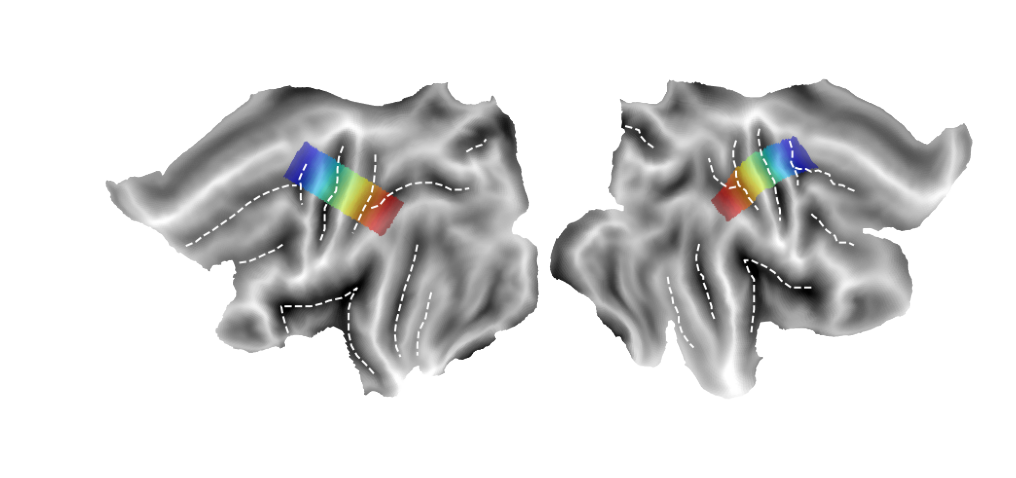

In [15]:
show_both_hemi_sampling_coverage(l_sampling_coverage = l_cross_section_result_info_onDiscrete["sampling_coverages"],
                                 r_sampling_coverage = l_cross_section_result_info_onDiscrete["sampling_coverages"],
                                 save_dir_path = save_dir_path,
                                 surf_resolution = surf_resolution)

# 1D-plot for sampling areas

## Detect names

In [19]:
def get_rois(sampling_coverages, hemisphere):
    rois = detect_roi_names(sampling_coverages, hemisphere)
    rois = [roi.replace("|", "") for roi in rois]
    rois = np.array([roi.replace(f"{hemisphere}_", "") for roi in rois])
    rois[np.where(rois == "2")[0]] = "1+2+3"
    rois = np.where(rois == "1+2+3", "3+1+2", rois)
    rois = np.array([roi.replace("+", ", ") for roi in rois])

    return rois

In [21]:
# Suclus names
l_sulcus_names = detect_sulcus("L", l_cross_section_result_info_onDiscrete["sampling_coverages"], False)
r_sulcus_names = detect_sulcus("R", r_cross_section_result_info_onDiscrete["sampling_coverages"], False)[::-1]
r_sulcus_names[-1] = ""

# region names
l_roi_names = get_rois(l_cross_section_result_info_onDiscrete["sampling_coverages"], hemisphere = "L")
r_roi_names = get_rois(r_cross_section_result_info_onDiscrete["sampling_coverages"], hemisphere = "R")[::-1]

## Stats

In [64]:
p_threshold = 0.05

l_sampling_datas = [l_cross_section_result_info_onDiscrete["sampling_datas"], l_cross_section_result_info_onContinuous["sampling_datas"]]
r_sampling_datas = [r_cross_section_result_info_onDiscrete["sampling_datas"][::-1], r_cross_section_result_info_onContinuous["sampling_datas"][::-1]]

# Plotting

In [65]:
def draw_both_hemi_cross_section_1dPlot(cmap = "tab10", y_range = None):
    fig, axes = plt.subplots(1, 2, sharey=True)
    fig.set_figwidth(15)
    
    draw_cross_section_1dPlot(ax = axes[0], 
                              sampling_datas = l_sampling_datas, 
                              sulcus_names = l_sulcus_names, 
                              roi_names = l_roi_names,
                              p_threshold = 0.05,
                              y_range = y_range,
                              tick_size = 24,
                              sulcus_text_size = 16,
                              cmap = cmap)

    # xmin, xmax = axis[0].get_xlim()
    axes[0].hlines(y=0., xmin=0, xmax=30, color='k', linestyle='--')
    
    draw_cross_section_1dPlot(ax = axes[1], 
                              sampling_datas = r_sampling_datas, 
                              sulcus_names = r_sulcus_names, 
                              roi_names = r_roi_names,
                              p_threshold = 0.05,
                              y_range = y_range,
                              tick_size = 24,
                              sulcus_text_size = 16,
                              cmap = cmap)
    
    axes[0].set_xlabel("")
    axes[1].set_xlabel("")
    axes[0].set_ylabel("")
    axes[1].set_ylabel("")
    axes[1].get_yaxis().set_visible(False)
    axes[1].spines['left'].set_visible(False)
    axes[1].hlines(y=0., xmin=0, xmax=30, color='k', linestyle='--')
    # fig.supxlabel("Brodmann area", fontsize = 18, fontweight = "bold", y = -0.01)
    fig.subplots_adjust(wspace = 0.1)

    return fig, axes

In [66]:
def draw_cross_section_1dPlot(ax, 
                              sampling_datas, 
                              sulcus_names, 
                              roi_names,
                              p_threshold = 0.05,
                              y_range = None,
                              tick_size = 18,
                              sulcus_text_size = 10,
                              y_tick_round = 4,
                              cmap = "tab10",
                              xlabel = "Brodmann area",
                              ylabel = "Distance (a.u.)"):
    """
    Draw 1d plot for cross-section coverage analysis
    
    :param ax(plt.Axes): Matplotlib Axes object where the plot will be drawn
    :param sampling_datas(np.array): 3D array of shape (n_condition, n_sampling_coverage, n_data) with data to be plotted
    :param sulcus_names(np.array): 1D array containing sulcus names for each condition (can be empty strings or None)
    :param roi_names(np.array): 1D array containing ROI (Region of Interest) names for each condition
    :param p_threshold(float): P-value threshold for marking significant areas (default is 0.05)
    :param y_range(tuple): specifying y-axis limits (e.g., (y_min, y_max)). If None, limits are calculated automatically
    """

    n_cond, n_coverage, n_samples = 2, 30, None
    
    y_min_padding = 0
    y_max_padding = 0

    cmap = plt.get_cmap(cmap)
    cmap_colors = cmap.colors
    
    # Plot
    is_set_minMax = False
    if type(y_range) != type(None):
        y_min_, y_max_ = y_range
        is_set_minMax = True
        print(y_min_, y_max_)
    else:
        y_min_ = None
        y_max_ = None
    
    for cond_i, sampling_data in enumerate(sampling_datas):
        color = cmap_colors[cond_i]
        
        xs = np.arange(sampling_data.shape[0]).astype(str)
        mean_values = np.mean(sampling_data, axis = 1)
        errors = sem(sampling_data, axis = 1)
        ax.plot(xs, mean_values, color = color)
        ax.fill_between(xs,
                        mean_values - errors, mean_values + errors, 
                        alpha = 0.2,
                        color = color)

        if is_set_minMax == False:
            if y_min_ == None:
                y_min_ = np.min(mean_values - errors)
                
            if y_max_ == None:
                y_max_ = np.max(mean_values + errors)
                
            y_min_ = min(y_min_, np.max(mean_values - errors))
            y_max_ = max(y_max_, np.max(mean_values + errors))
    
    # Set ticks
    n_div = 3 
    interval = (y_max_ - y_min_) / n_div
    y_data = np.arange(y_min_, y_max_ + interval, interval)
    y_data = np.round(y_data, y_tick_round)
    y_data = [0 if y == 0 else y for y in y_data]
    
    unique_rois = np.unique(roi_names)
    roi_names = copy(roi_names)
    roi_start_indexes = np.array(sorted([list(roi_names).index(roi) for roi in unique_rois])) # Select start index of ROI
    roi_names[roi_start_indexes] = ""
    
    tick_info = {}
    tick_info["x_data"] = np.arange(len(roi_names))
    tick_info["x_names"] = roi_names
    tick_info["x_tick_rotation"] = 0
    tick_info["x_tick_size"] = tick_size
    tick_info["y_data"] = y_data
    tick_info["y_names"] = y_data
    tick_info["y_tick_size"] = tick_size
    draw_ticks(ax, tick_info)
    
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.{y_tick_round}f}"))
    
    # Draw spines
    draw_spine(ax)

    # Draw labels
    label_info = {}
    label_info["x_label"] = xlabel
    label_info["y_label"] = ylabel
    label_info["x_size"] = tick_size
    label_info["y_size"] = tick_size
    draw_label(ax, label_info)

    # Sulcus
    sulcus_indexes = np.where(sulcus_names != None)[0]
    if (len(sulcus_indexes) > 0) and (len(sulcus_names) > 0):
        y_max_padding += (interval / 3)
            
        sulcuses = sulcus_names[sulcus_indexes]
        sulcus_indexes = np.where(sulcus_names != "")[0]
        for sulcus_i in sulcus_indexes:
            sulcus_name = sulcus_names[sulcus_i]
            sulcus_name = sulcus_abbreviation_name(sulcus_name)
            
            ax.text(x = sulcus_i, 
                    y = y_max_ + (y_max_padding * 1.5), 
                    s = sulcus_name,  
                    va = "center", 
                    ha = "center",
                    size = sulcus_text_size,
                    rotation = 30)
            
            ax.text(x = sulcus_i, 
                    y = y_max_ + (y_max_padding / 2), 
                    s = "▼",  
                    va = "center", 
                    ha = "center",
                    size = 11,
                    rotation = 0)

    # Show significant areas
    y_min_padding += interval
    rect_height = interval / 10

    max_height_forSig = n_cond * rect_height

    for cond_i, sampling_data in enumerate(sampling_datas):
        color = cmap_colors[cond_i]
        
        stat_result = ttest_1samp(sampling_data, popmean = 0, axis = 1)
        significant_indexes = np.where(stat_result.pvalue < p_threshold)[0]

        cond_number = cond_i + 1
        y = y_min_ - y_min_padding + max_height_forSig - (rect_height * cond_number)

        for sig_i in significant_indexes:
            ax.add_patch(Rectangle(xy = (sig_i, y), 
                                   width = 1, 
                                   height = rect_height, 
                                   color = color))

    # Draw roi
    for roi_start_i in list(roi_start_indexes) + [len(roi_names) - 1]:
        ax.axvline(x = roi_start_i, 
                   color = "black", 
                   linestyle = "dashed", 
                   alpha = 0.3,
                   ymin = 0,
                   ymax = (y_max_ - y_min_ + y_min_padding) / (y_max_ - y_min_ + y_min_padding + y_max_padding))

    ax.set_xlim(0, n_coverage - 1)
    ax.set_ylim(y_min_ - y_min_padding, y_max_ + y_max_padding)

In [67]:
from scipy.stats import sem

In [68]:
from sj_matplotlib import draw_ticks, draw_spine, draw_label
from surface_analysis import sulcus_abbreviation_name

0 1.5
0 1.5
save: /mnt/ext1/seojin/temp/both_hemi_1dplot.png


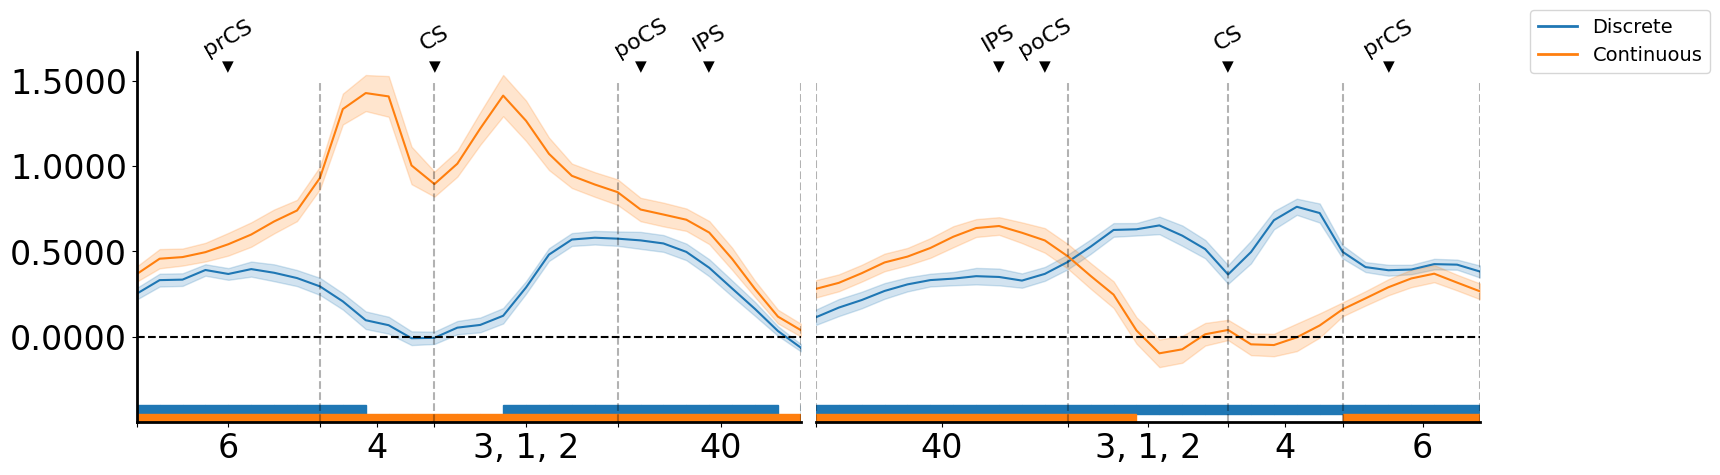

In [69]:
fig, axis = draw_both_hemi_cross_section_1dPlot(cmap = "tab10", y_range = (0, 1.5))

cmap = plt.get_cmap("tab10", 10)
custom_lines = [Line2D([0], [0], color = cmap.colors[0], lw = 2, label = "Discrete"),
                Line2D([0], [0], color = cmap.colors[1], lw = 2, label = "Continuous")]

# Add the legend to the figure
fig.legend(handles = custom_lines, 
           loc = "upper right", 
           ncol = 1, 
           bbox_to_anchor=(1.15, 1),
           fontsize = 14)

fig.tight_layout()
file_path = os.path.join(save_dir_path, "both_hemi_1dplot.png")
fig.savefig(file_path, transparent = True, bbox_inches = "tight")
print(f"save: {file_path}")